## Seasonal Autoregressive Integrated Moving-Average with eXogenous regressors (SARIMAX)
The SARIMAX class is an example of a fully fledged model created using the statespace backend for estimation. SARIMAX can be used very similarly to tsa models, but works on a wider range of models by adding the estimation of additive and multiplicative seasonal effects, as well as arbitrary trend polynomials.

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import seaborn as sns
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
sns.set(font_scale=1.2)
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["lines.linewidth"] = 1.0

In [6]:
# Dataset
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
data.index.freq = 'QS-OCT'

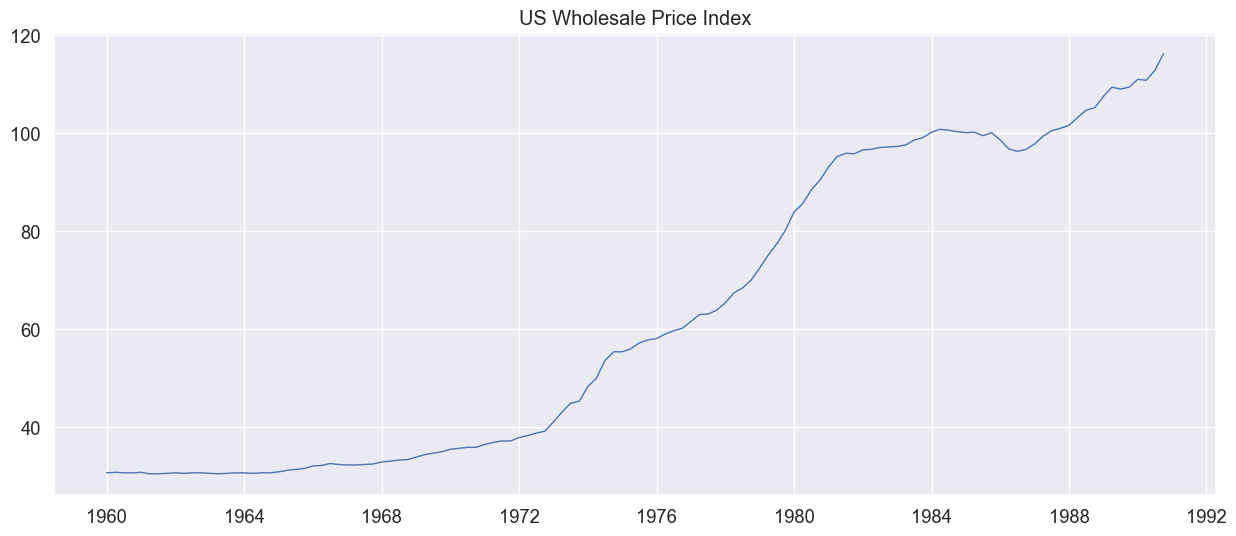

In [14]:
fig, ax = plt.subplots()
ax.plot(data.index._mpl_repr(), data['wpi'], '-')
ax.set(title='US Wholesale Price Index');

### ARIMA Example 1: Arima
As shown in the graph above, the Wholesale Price Index (WPI) is growing over time (i.e. not stationary). Therefore an ARMA model is not a good specification. In this first example, we consider a model where the original time series is assumed to be integrated of order 1, so that the difference is assumed to be stationary, and fit a model with one autoregressive lag and one moving average lag, as well as an intercept term.

The postulated data process is then:
$$
\Delta y_t = c + \phi_1\Delta y_{t-1} + \phi_1\varepsilon_{t-1} + \varepsilon_t,
$$
where $c$ is the intercept of the ARMA model, $\Delta$ is the first-difference operator, and we assume $\varepsilon\sim N(0,\sigma^2)$. This can be rewritten to emphasise lag polynomials using the Backshift operator.
$$
(1-\phi_1B)(1-B)y_t = c + (1+\phi_1B)\varepsilon_t,
$$
where $B$ is the backshift operator.

In [28]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -135.351
Date:                Thu, 28 Nov 2024   AIC                            278.703
Time:                        14:30:00   BIC                            289.951
Sample:                    01-01-1960   HQIC                           283.272
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0943      0.068      1.389      0.165      -0.039       0.227
ar.L1          0.8742      0.055     16.028      0.000       0.767       0.981
ma.L1         -0.4120      0.100     -4.119      0.0

Thus the maximum likelihood estimates implies that for the process above, we have:
$$
\Delta y_t = 0.0943 + 0.8742\Delta y_{t-1} - 0.4120\varepsilon_{t-1} + \varepsilon,
$$
where $\varepsilon_t\sim N(0, 0.5257)$.

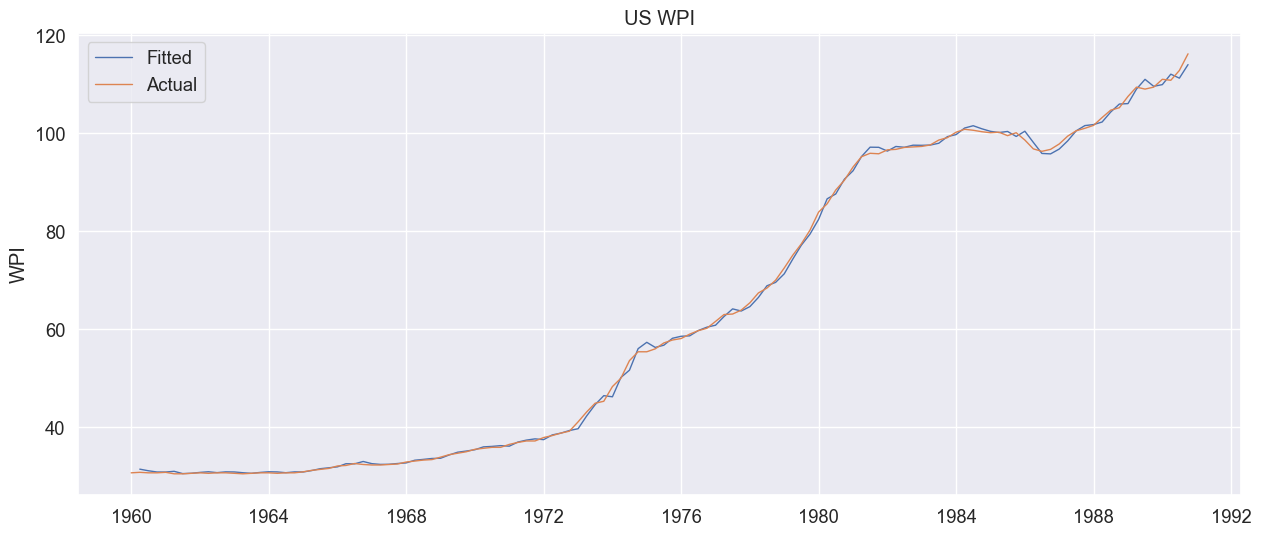

In [31]:
plt.plot(res.fittedvalues[1:], label='Fitted')
plt.plot(data['wpi'], label='Actual')
plt.ylabel('WPI')
plt.title('US WPI')
plt.legend()

### ARIMA Example 2: Arima with additive seasonal effects
This model is an extension of that from example 1. Here the data is assumed to follow the process:
$$
\Delta y_t = c + \phi\Delta y_{t-1} + \theta_1\varepsilon_{t-1} + \theta_4\varepsilon_{t-4} + \varepsilon_t.
$$
The new part of this model is that there is allowed to be an annual seasonal effect (it is annual even though the periodicity is 4 because of the dataset is quarterly). The second difference is that this model uses the log of the data rather than the level.

We show the following graphs:
1. The time series (in logs)
2. The first difference of the time series (in logs)
3. The autocorrelation function
4. The partial autocorrelation function.

From the first two graphs, we note that the original time series does not appear to be stationary, whereas the first-difference does. This supports either estimating an ARMA model on the first-difference of the data, or estimating an ARIMA model with 1 order of integration (recall that we are taking the latter approach). The last two graphs support the use of an ARMA(1,1,1) model.


In [11]:
data['ln_wpi'] = np.log(data['wpi'])
data['D.ln_wpi'] = data['ln_wpi'].diff()

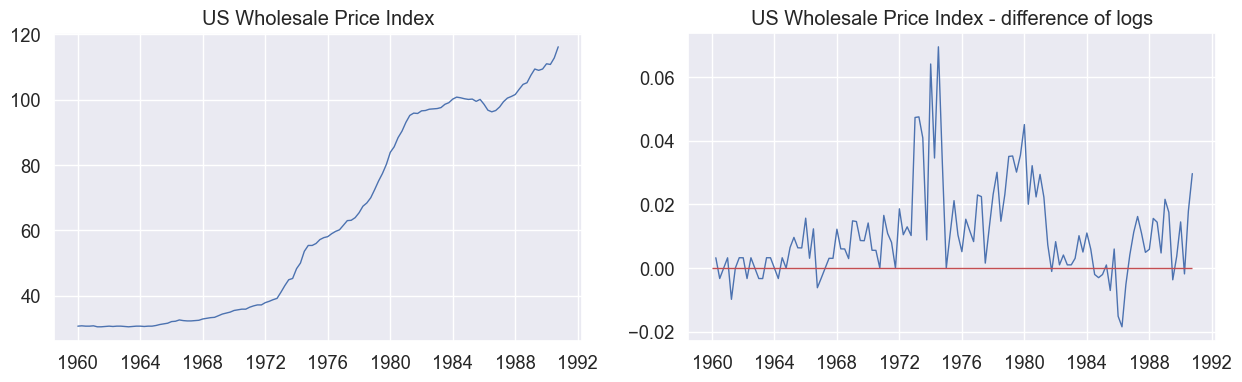

In [15]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Levels
axes[0].plot(data.index._mpl_repr(), data['wpi'], '-')
axes[0].set(title='US Wholesale Price Index')

# Log difference
axes[1].plot(data.index._mpl_repr(), data['D.ln_wpi'], '-')
axes[1].hlines(0, data.index[0], data.index[-1], 'r')
axes[1].set(title='US Wholesale Price Index - difference of logs');

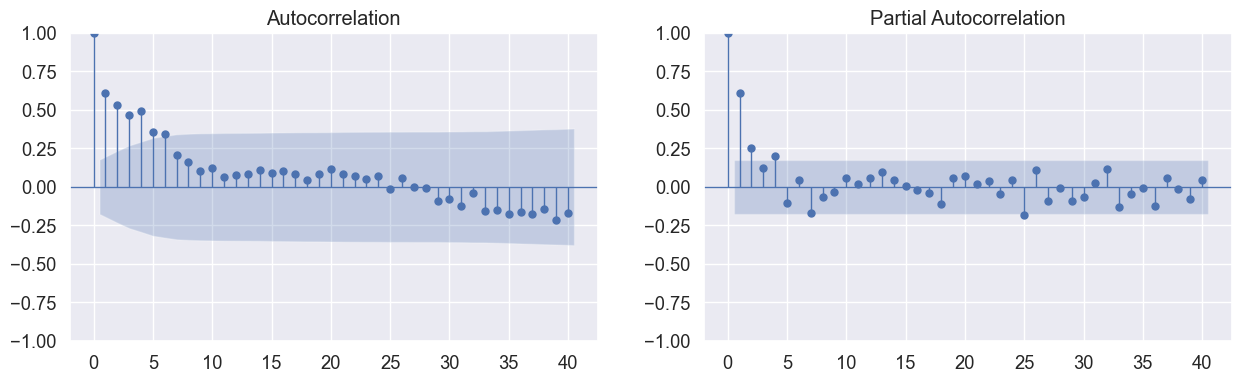

In [16]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[1])

Test for stationarity using the [Augmented Dickey-Fuller test](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)
- Null hypothesis is that there is a unit root in a univariate process the presence of serial correlation.
- Alternative hypothesis is that the series is stationary (no unit root).

In this case the $p$-value is 0.14, which means we can't reject that there is a unit root. But we are going to continue with the notebook anyway.

In [20]:
sm.tsa.stattools.adfuller(data['D.ln_wpi'].dropna()) 

(-2.3839763248732098,
 0.1463101389813673,
 3,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 -662.2871151198704)

What we want is a polynomial that has terms for the 1st and 4th degrees, but leaves out the 2nd and 3rd terms. To do that, we need to provide a tuple for the specification parameter, where the tuple describes **the lag polynomial itself**. In particular, here we would want to use:
```
ar = 1              # this is the maximum degree specification
ma = (1, 0, 0, 1)   # this is the lag polynomial specification
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(ar, 1, ma))
```
This gives the following form for the process of the data:
$$
\begin{align*}
\Delta y_t & = c + \phi_1\Delta y_{t-1} + \theta_1\varepsilon_{t-1} + \theta_4\varepsilon_{t-4} + \varepsilon_t \\
(1 - \phi_1 B)\Delta y_t & = c + (1+\theta_1 B + \theta_4 B^4)\varepsilon_t,
\end{align*}
$$
which is what we want.

In [21]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(
    data["ln_wpi"], trend="c", order=(1, 1, (1, 0, 0, 1))
)
res = mod.fit(disp=0)
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:                    ln_wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood                 386.034
Date:                   Thu, 28 Nov 2024   AIC                           -762.067
Time:                           14:25:48   BIC                           -748.006
Sample:                       01-01-1960   HQIC                          -756.356
                            - 10-01-1990                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.485      0.138      -0.001       0.006
ar.L1          0.7808      0.094      8.271      0.000       0.596       0.966
ma.L1         -0.3991      0

Text(0.5, 1.0, 'Log WPI')

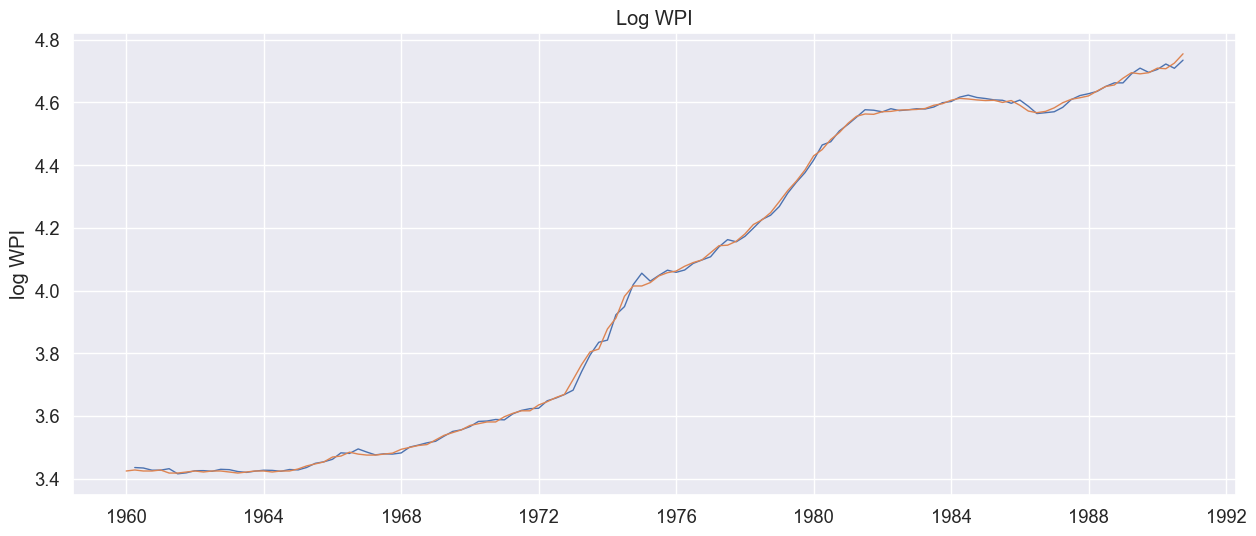

In [27]:
plt.plot(res.fittedvalues[1:])
plt.plot(data['ln_wpi']);
plt.ylabel('log WPI')
plt.title('Log WPI')

### ARIMA Example 3: Airline Model
In the previous example, we included a seasonal effect in an *additive* way, meaning that we added a term allowing the process to depend on the 4th MA lag. It may be instead that we want to model a seasonal effect in a multiplicative way. We often write the model then as an ARIMA $(p, d, q)\times(P, D, Q)_s$, where the lowercase letters indicate the specification for the non-seasonal component, and the uppercase letters indicate the specification for the seasonal component; $s$ is the periodicity of the season (e.g. it is often 4 for quarterly data or 12 for monthly data). The data process can be written generically as

$$
\phi_p(B)\tilde{\phi}_P(B^s)\Delta^d\Delta_s^Dy_t = A(t) + \theta_q(B)\tilde{\theta}_Q(L^s)\varepsilon_t,
$$
where
- $\phi_p(B)$ is the non-seasonal autoregressive lag polynomial
- $\tilde{\phi}_P(B^s)$ is the seasonal autoregressive lag polynomial
- $\Delta^d\Delta_s^Dy_t$ is the time series, differenced $d$ times, and seasonally differenced $D$ times.
- $A(t)$ is the trend polynomial (including the intercept)
- $\theta_q(B)$ is the non-seasonal moving average lag polynomial
- $\tilde{\theta}_Q(L^s)$ is the seasonal moving average lag polynomial

Basically, after we take differences (here both non-seasonal and seasonal) to make the data stationary, the resulting model is just an ARMA model. 

As an example, consider the airline model ARIMA$(2, 1, 0)\times(1, 1, 0)_{12}$, with an intercept. The data process can be written in the form above as:
$$
(1-\phi_1B - \phi_2B^2)(1-\tilde{\phi}_1B^{12})\Delta\Delta_{12}y_t = c + \varepsilon_t
$$

In [32]:
# Dataset
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data = pd.read_stata(BytesIO(air2))
data.index = pd.date_range(start=datetime(int(data.time[0]), 1, 1), periods=len(data), freq='MS')
data['lnair'] = np.log(data['air'])

# Fit the model
mod = sm.tsa.statespace.SARIMAX(data['lnair'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       D.DS12.lnair   No. Observations:                  131
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 240.821
Date:                            Thu, 28 Nov 2024   AIC                           -473.643
Time:                                    14:52:33   BIC                           -462.142
Sample:                                02-01-1950   HQIC                          -468.970
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4057      0.080     -5.045      0.000      -0.563      -0.248
ar.L2         -0.0799      0.099   

### ARIMA Example 4: ARMAX (Friedman)
This model demonstrates the use of explanatory variables (the X part of ARMAX). When exogenous regressors are included, the SARIMAX module uses the concept of "regression with SARIMA errors", so that the model is specified as:
$$
\begin{align*}
y = \beta_tx_t + u_t & \\
\phi_p(B)\tilde{\phi}_P(B^s)\Delta^d\Delta_s^Du_t = A(t) + \theta_q(B)\tilde{Q}(L^s)\varepsilon_t &
\end{align*}
$$
Notice that the first equation is just a linear regression, and the second equation just describes the process followed by the error component as SARIMA (as was described in example 3). One reason for this specification is that the estimated parameters have their natural interpretations.

In [37]:
# Dataset
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
data = pd.read_stata(BytesIO(friedman2))
data.index = data.time
data.index.freq = "QS-OCT"

In [40]:
# Variables
endog = data.loc['1959':'1981', 'consump']
exog = sm.add_constant(data.loc['1959':'1981', 'm2'])

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1, 0, 1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   92
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -340.508
Date:                Thu, 28 Nov 2024   AIC                            691.015
Time:                        15:02:37   BIC                            703.624
Sample:                    01-01-1959   HQIC                           696.105
                         - 10-01-1981                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.0610     56.640     -0.637      0.524    -147.074      74.951
m2             1.1220      0.036     30.826      0.000       1.051       1.193
ar.L1          0.9348      0.041     22.718      0.0